### Setup

In [2]:
!pip install -Uqq diffusers transformers datasets accelerate ftfy bitsandbytes==0.35.0 wandb

### Dataset

In [3]:
import torch
from torch import Tensor
import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import List, Dict
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from transformers import CLIPFeatureExtractor, CLIPTextModel
from argparse import Namespace
import random
from tqdm.auto import tqdm
import math
import wandb
import os
import itertools
import datetime
import pytz

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tensor2pil = transforms.ToPILImage()
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
from datasets import load_dataset

# dataset_name = 'lewtun/corgi'
dataset_name = 'matteopilotto/kratos'
dataset = load_dataset(dataset_name, split='train')

dataset

Using custom data configuration matteopilotto--kratos-34c4f8400ee7980d


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/10 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/matteopilotto___parquet/matteopilotto--kratos-34c4f8400ee7980d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Dataset({
    features: ['image'],
    num_rows: 10
})

In [8]:
from PIL import Image

def image_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    
    return grid

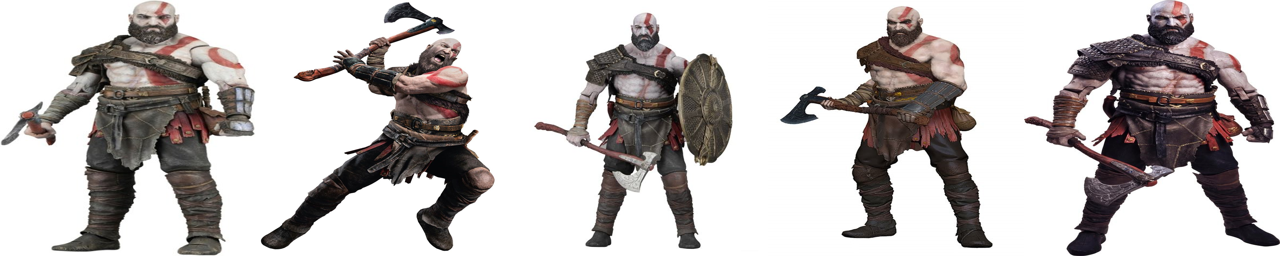

In [9]:
image_grid([image.resize((256, 256)) for image in dataset['image']], rows=1, cols=5)

In [10]:
# unique_id = 'ccorgi'
# class_type = 'dog'
# instance_prompt = f'a photo of {unique_id} {class_type}'
# print(instance_prompt)

In [11]:
# unique_id = 'pplt' # meaning "pork pig looney tunes"
# class_type = 'pig'
# instance_prompt = f'a photo of {unique_id} {class_type}'
# print(instance_prompt)

unique_id = 'krts' # meaning "pork pig looney tunes"
class_type = 'person'
instance_prompt = f'a photo of {unique_id} {class_type}'
print(instance_prompt)

a photo of krts person


In [12]:
from torch.utils.data import Dataset
from torchvision import transforms

class DreamBoothDataset(Dataset):
    def __init__(self, dataset, instance_prompt, tokenizer, img_size=512):
        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        # self.img_size = img_size
        
        self.img_transforms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            # transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]['image']
        example['instance_image'] = self.img_transforms(image)
        example['instance_input_ids'] = self.tokenizer(
                                            self.instance_prompt,
                                            padding='do_not_pad',
                                            truncation=True,
                                            max_length=self.tokenizer.model_max_length
                                        ).input_ids
        
        return example

In [13]:
from transformers import CLIPTokenizer

sd_ckpt = 'CompVis/stable-diffusion-v1-4'
tokenizer = CLIPTokenizer.from_pretrained(sd_ckpt, subfolder='tokenizer')

train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer, img_size=512)

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

### Dataloader

In [ ]:
train_dataset[0]['instance_image'].shape

In [ ]:
def collate_fn(examples: List[Dict[str, Tensor]]) -> Dict[str, List[Tensor]]:
    input_ids = [example['instance_input_ids'] for example in examples]
    pixel_values = [example['instance_image'] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    
    input_ids = tokenizer.pad({'input_ids': input_ids}, padding=True, return_tensors='pt').input_ids
    
    batch = {'input_ids': input_ids,
             'pixel_values': pixel_values}
    
    return batch

In [ ]:
examples = [train_dataset[i] for i in range(len(train_dataset))]
batch = collate_fn(examples)
# batch

In [ ]:
for image in batch['pixel_values']:
    display(tensor2pil(image).resize((256, 256)))

In [ ]:
text_encoder = CLIPTextModel.from_pretrained(sd_ckpt, subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained(sd_ckpt, subfolder='vae')
unet = UNet2DConditionModel.from_pretrained(sd_ckpt, subfolder='unet')
feature_extractor = CLIPFeatureExtractor.from_pretrained('openai/clip-vit-base-patch32')

In [ ]:
batch_size = 1

train_dl = DataLoader(dataset=train_dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      collate_fn=collate_fn)

In [ ]:
batch = next(iter(train_dl))
# batch

In [ ]:
batch['pixel_values'].shape

### Fine-tuning with Accelerate

In [ ]:
lr = 2e-6
max_train_steps = 880
sample_prompts = [
    f'an illustration of {unique_id} {class_type} wearing a Santa hat in a snowy forest',
    f'a photograph of {unique_id} {class_type} reading a book on the beach',
    f'a sketch of {unique_id} {class_type} painting a mountain landscape',
    f'a drawing of {unique_id} {class_type} wearing a Spider-man costume in the style of Marvel comics'
]

from argparse import Namespace

args = Namespace(
    pretrained_model_name_or_path=sd_ckpt,
    resolution=512, # Reduce this if you want to save some memory
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    learning_rate=lr,
    max_train_steps=max_train_steps,
    train_batch_size=1,
    gradient_accumulation_steps=1, # Increase this if you want to lower memory usage
    max_grad_norm=1.0,
    gradient_checkpointing=True,  # set this to True to lower the memory usage.
    use_8bit_adam=True,  # use 8bit optimizer from bitsandbytes
    seed=2077,
    eval_batch_size=1,
    output_dir="my-dreambooth", # where to save the pipeline
    project_name='dreambooth-kratos',
    guidance_scale=7,
    # sample_prompt=f"a photo of {unique_id} {class_type} with a Santa hat in the snowny forest.",
    train_text_encoder=True,
    eval_samples_every_epochs=5,
    sample_prompts=sample_prompts
)

In [ ]:
def train_fn(text_encoder, vae, unet):
    
    # init Accelerator
    accelerator = Accelerator(gradient_accumulation_steps=args.gradient_accumulation_steps,
                              log_with="wandb",
                              logging_dir=os.path.join(args.output_dir, 'logs'))
    
    # set seed
    set_seed(args.seed)
    
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)
    text_encoder.to(accelerator.device)
    
    vae.requires_grad_(False)
    vae.to(accelerator.device)
    
    feature_extractor = CLIPFeatureExtractor.from_pretrained('openai/clip-vit-base-patch32')
    
    # enable gradient checkpointing
    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        
    # optimizer
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW
    
    # ref. itertools.chain: https://discuss.pytorch.org/t/giving-multiple-parameters-in-optimizer/869/8?u=matteo_pilotto
    if args.train_text_encoder:
        params_to_optimize = itertools.chain(unet.parameters(), text_encoder.parameters())
    else:
        params_to_optimize = unet.parameters()
        
    optimizer = optimizer_class(params=params_to_optimize, lr=args.learning_rate)
    
    # init noise scheduler
    noise_scheduler = DDPMScheduler(
        beta_start=8.5e-4,
        beta_end=1.2e-2,
        beta_schedule='scaled_linear',
        num_train_timesteps=1000
    )
    
    # init inference scheduler
    inference_scheduler = PNDMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        skip_prk_steps=True,
        steps_offset=1,
    )
    
    # define train dataloader
    train_dl = DataLoader(dataset=args.train_dataset,
                          batch_size=args.train_batch_size,
                          collate_fn=collate_fn,
                          shuffle=True)
    
    # calculate the total number of epochs based on the number of training steps adjusted to grad. acc. steps
    train_steps_per_epoch = math.ceil(len(train_dl) / args.gradient_accumulation_steps)
    train_epochs = math.ceil(args.max_train_steps / train_steps_per_epoch)
    
    # total batch size
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps
    
    # prepare unet, optimizer and train dataloader to work with Accelerate
    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dl = accelerator.prepare(unet, text_encoder, optimizer, train_dl)
    else:
        unet, optimizer, train_dl = accelerator.prepare(unet, optimizer, train_dl)
    
    # init tracker
    if accelerator.is_main_process:
        accelerator.init_trackers(project_name=args.project_name, config=args)
    
    # init WANDB table
    log_prompts = [prompt for prompt in args.sample_prompts for i in range(args.eval_batch_size)]
    log_table = wandb.Table(columns=['prompt'])
    for prompt in log_prompts:
        log_table.add_data(prompt)
    
    # init progress bar
    progress_bar = tqdm(range(args.max_train_steps), disable=(not accelerator.is_local_main_process))
    progress_bar.set_description('Steps')
    global_step = 0
    
    # training loop
    for epoch in range(train_epochs):
        unet.train()
        
        if args.train_text_encoder:
            text_encoder.train()
            
        for i, batch in enumerate(train_dl):
            with accelerator.accumulate(unet):
                # compute latents (i.e. image embeddings)
                with torch.inference_mode():
                    latents = vae.encode(batch['pixel_values']).latent_dist.sample()
                    latents *= 0.18215

                # init noise
                noise = torch.randn_like(latents).to(accelerator.device)

                # compute random timesteps
                batch_size = latents.shape[0]
                num_train_ts = noise_scheduler.num_train_timesteps
                timesteps = torch.tensor([random.randint(0, num_train_ts-1) for _ in range(batch_size)])
                timesteps = timesteps.to(accelerator.device)

                # add noise to latents
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # compute text embeddings
                # with torch.inference_mode():
                #     text_embeds = text_encoder(batch['input_ids'])[0]
                # text_embeds = torch.clone(text_embeds)
                text_embeds = text_encoder(batch['input_ids'])[0]
                

                # predict noise (forward pass)
                noise_pred = unet(noisy_latents, timesteps, text_embeds).sample

                # compute loss
                loss = F.mse_loss(noise_pred, noise, reduction='none').mean([1, 2, 3]).mean()

                # backward pass
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    if args.train_text_encoder:
                        params_to_clip = itertools.chain(unet.parameters(), text_encoder.parameters())
                    else:
                        params_to_clip = unet.parameters()
                        
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)

                # optimizer step & zero grad
                optimizer.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item(),
                    'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                    'step': global_step,
                    'epoch': epoch+1}
            
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

            if global_step >= args.max_train_steps:
                break
                
        accelerator.wait_for_everyone()
        
        # Generate sample images for visual inspection
        if accelerator.is_main_process:
            if (epoch+1) % args.eval_samples_every_epochs == 0:
                print(f'[INFO] Generating samples for Epoch {epoch+1}...')
                
                pipeline = StableDiffusionPipeline(
                    text_encoder=accelerator.unwrap_model(text_encoder),
                    vae=vae,
                    unet=accelerator.unwrap_model(unet),
                    tokenizer=tokenizer,
                    scheduler=inference_scheduler,
                    safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
                    feature_extractor=feature_extractor,
                ).to(accelerator.device)
                
                sample_images = []
                for sample_prompt in sample_prompts:
                    generator = torch.Generator(device=pipeline.device).manual_seed(args.seed)
                
                    # run pipeline in inference (sample random noise and denoise)
                    for _ in range(args.eval_batch_size):
                        print(f'[INFO] generating image for "{sample_prompt}" prompt...')
                        images = pipeline(
                            prompt=sample_prompt,
                            guidance_scale=args.guidance_scale,
                            generator=generator).images
                        
                        sample_images.extend(images)

                # accelerator.trackers[0].log({"examples": [wandb.Image(image) for image in sample_images]})
                log_images = [wandb.Image(image) for image in sample_images]
                accelerator.trackers[0].log({"sample images": log_images})
                log_table.add_column(name=f'epoch_{epoch+1}', data=log_images)
                # accelerator.trackers[0].log({'examples': log_table})
    
    
    if accelerator.is_main_process:
        # log_table = wandb.Table(data=list(zip(sample_prompts, log_images)), columns=['prompt', 'image'])
        accelerator.trackers[0].log({'table': log_table})
    
    if accelerator.is_main_process:
        print(f'[INFO] Loading pipeline and saving it to {args.output_dir}')
        
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=inference_scheduler,
            feature_extractor=feature_extractor,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained('CompVis/stable-diffusion-safety-checker')
        )
        
        pipeline.save_pretrained(args.output_dir)

    accelerator.end_training()

In [ ]:
# wandb.finish()

In [ ]:
from accelerate import notebook_launcher

# init models
text_encoder = CLIPTextModel.from_pretrained(sd_ckpt, subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained(sd_ckpt, subfolder='vae')
unet = UNet2DConditionModel.from_pretrained(sd_ckpt, subfolder='unet')
feature_extractor = CLIPFeatureExtractor.from_pretrained('openai/clip-vit-base-patch32')

num_of_gpus = 1
notebook_launcher(train_fn, args=(text_encoder, vae, unet), num_processes=num_of_gpus)

### Save model

In [ ]:
# SAVE MODEL'S CHECKPOINT ON WANDB 

# ref: https://docs.wandb.ai/guides/track/advanced/resuming
# ref: https://docs.wandb.ai/ref/python/artifact

PROJECT_NAME = 'dreambooth-kratos'
RUN_ID = 'ay51iqly'
MODEL_PATH = f'./my-dreambooth'

with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=True) as run:
    artifact = wandb.Artifact(RUN_ID, type='model')
    artifact.add_dir(MODEL_PATH)
    run.log_artifact(artifact)

### Download model from WANDB

In [ ]:
# DOWNLOAD MODEL'S CHECKPOINT FROM WANDB

PROJECT_NAME = 'dreambooth-kratos'
RUN_ID = 'ay51iqly'
with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=True) as run:
    artifact = wandb.use_artifact(f'matt24/{PROJECT_NAME}/{RUN_ID}:v0', type='model')
    artifact_dir = artifact.download()

print(f'[INFO] Artifact directory: {artifact_dir}')

### Inference

In [ ]:
load_from_wandb = True

if load_from_wandb:
    print('[INFO] Loading fine-tuned model from WANDB...')
    pipeline = StableDiffusionPipeline.from_pretrained(artifact_dir, torch_dtype=torch.float16).to(device)
else:
    print('[INFO] Load fine-tuned model from local directory...')
    pipeline = StableDiffusionPipeline.from_pretrained(args.output_dir, torch_dtype=torch.float16).to(device)

In [ ]:
# number of images to generate
num_samples = 16

# pipeline paramters
sample_prompts = [
    f'an illustration of {unique_id} {class_type} wearing a Santa hat in a snowy forest',
    f'a photograph of {unique_id} {class_type} reading a book on the beach',
    f'a sketch of {unique_id} {class_type} painting a mountain landscape',
    f'a drawing of {unique_id} {class_type} wearing a Spider-man costume in the style of Marvel comics'
]

prompt = f"an illustration of stylish {unique_id} {class_type} in the style of 90's vintage anime, surrealism, akira style. detailed line art. fine details. inside a 7/11 in tokyo"

negative_prompt = 'low contrast, blurry, low resolution, warped'
guidance_scale = 7
h = 512
w = 512
num_inference_steps = 50


# wandb parameters
PROJECT_NAME = 'dreambooth-kratos'
RUN_ID = 'ay51iqly'
inference_table_name = 'inference_table'
log_table_cols = [
    'image',
    'prompt',
    'negative prompt',
    'resolution',
    'guidance scale',
    'inference steps',
    'seed'
]


'''
for the time being this part stays commented out because I couldn't figure out how to
programmaticly add new rows to an existing table previously logged on WANDB.
'''
# try:
#     print('[💡INFO] Checking for pre-existing inference table...')
#     with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=True) as run:
#         inference_log_table = (
#             run
#             .use_artifact(f"run-{RUN_ID}-{inference_table_name}:latest")
#             .get(inference_table_name)
#         )

# except:
#     print('[💡INFO] Inference table does not exist. Creating one...')
#     inference_log_table = wandb.Table(columns=log_table_cols)

# keep track of time
current_time = datetime.datetime.now(pytz.timezone('Europe/Amsterdam')).strftime("%Y-%m-%d_%H-%M-%S")

# initialize WANDB artficat and table
inference_artifact = wandb.Artifact(f'inference_artifact_{current_time}', type='inference') 
inference_log_table = wandb.Table(columns=log_table_cols)

# collect outputs
all_images = []
all_seeds = []



# generate images
for _ in tqdm(range(num_samples)):
    seed = random.randint(1, 1000000)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt,
                      negative_prompt=negative_prompt,
                      guidance_scale=guidance_scale,
                      height=h,
                      width=w,
                      num_inference_steps=num_inference_steps,
                      generator=generator
                     ).images[0]
    
    inference_log_table.add_data(
        wandb.Image(image),
        prompt,
        negative_prompt,
        f'{w} x {h}',
        guidance_scale,
        num_inference_steps,
        seed
    )
    
    all_images.append(image)
    all_seeds.append(seed)

inference_artifact.add(inference_log_table, 'inference_table')


with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=True) as run:
    print(f'[💡INFO] Saving dato to {inference_table_name}_{current_time}...')
    run.log_artifact(inference_artifact)
    
    
# image_grid(all_images, 1, num_cols)

### Prepare images

In [ ]:
PROJECT_NAME = 'dreambooth-kratos'
RUN_ID = 'ay51iqly'

with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=False) as run:
    artifact = run.use_artifact('inference_artifact_2023-01-11_21-38-22:latest')
    
table = artifact.get("inference_artifact_2023-01-11_21-38-22")

### Push on the Hub

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [19]:
# Create a name for your model on the Hub. No spaces allowed.
model_name = f'{unique_id}_{class_type}'
print(model_name)


theme = 'wildcard'

# Describe the theme and model you've trained
description = f"""
This is a Stable Diffusion model fine-tuned on imagaes of Kratos from God of War for the {theme} theme using `CompVis/stable-diffusion-v1-4` pre-trained model.
"""

print(description)

krts_person

This is a Stable Diffusion model fine-tuned on imagaes of Kratos from God of War for the wildcard theme using `CompVis/stable-diffusion-v1-4` pre-trained model.



In [15]:
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

In [16]:
get_full_repo_name(model_name)

'matteopilotto/krts_person'

In [ ]:
# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path=args.output_dir, path_in_repo="", repo_id=hub_model_id)

content = f"""
---
license: creativeml-openrail-m
tags:
- pytorch
- diffusers
- stable-diffusion
- text-to-image
- diffusion-models-class
- dreambooth-hackathon
- {theme}
widget:
- text: {prompt}
---

# DreamBooth model for the {name_of_your_concept} concept trained by {api.whoami()["name"]} on the {dataset_id} dataset.

This is a Stable Diffusion model fine-tuned on the {name_of_your_concept} concept with DreamBooth. It can be used by modifying the `instance_prompt`: **{instance_prompt}**

This model was created as part of the DreamBooth Hackathon 🔥. Visit the [organisation page](https://huggingface.co/dreambooth-hackathon) for instructions on how to take part!

## Description

{description}

## Usage

```python
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
hub_url = card.push_to_hub(hub_model_id)
print(f"Upload successful! Model can be found here: {hub_url}")
print(
    f"View your submission on the public leaderboard here: https://huggingface.co/spaces/dreambooth-hackathon/leaderboard"
)